In [413]:
import sys  
sys.path.insert(0, './machine_learning_models')

from logistic_regression import logistic_regression
from stochastic_gradient_descent import stochastic_gradient_descent
from knn import knn
from kernel_svm import kernel_svm
from naive_bayes import naive_bayes
from random_forest import random_forest
from voting_classifier import voting_classifier
from gradient_boosting import gradient_boosting
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output
from itertools import product, combinations
import json
from sklearn.preprocessing import StandardScaler

In [414]:
league_id = 71 # Choose the league id

season_file = '2008-2021'

first_season = 2012
last_season = 2021

selected_columns = ['PTS_A', 'PTS_CON_A', 'FG_PCT_A', 'FG3_PCT_A', 'FT_PCT_A', 'REB_A', 'TOV_A', 'SEASON_A_PCT', 'PER_A', 'ELO_A', 'MATCHUP_A_PCT', 'HA_A_PCT', 'STREAK_A', 'LAST_GAMES_PCT_A', 'HA_LAST_GAMES_PCT_A', 'OFF_RTG_A', 'DEF_RTG_A',
                    'PTS_B', 'PTS_CON_B', 'FG_PCT_B', 'FG3_PCT_B', 'FT_PCT_B', 'REB_B', 'TOV_B', 'SEASON_B_PCT', 'PER_B', 'ELO_B', 'MATCHUP_B_PCT', 'HA_B_PCT', 'STREAK_B', 'LAST_GAMES_PCT_B', 'HA_LAST_GAMES_PCT_B', 'OFF_RTG_B', 'DEF_RTG_B']

min_threshold = 1.75
max_threshold = 10

num_model_combinations = 1

first_attr_index = 7

# default_stake = 50
bankroll = 2000
stake = 0.025

In [415]:
print('\nGetting data for the model...')

season = "{}-{}".format(first_season, last_season)

default_path = f'./leagues/{league_id}'
whole_dataset = pd.read_csv('./data/{}.csv'.format(season_file))
whole_dataset = whole_dataset.loc[(whole_dataset['ODDS_A'].notna()) & (whole_dataset['ODDS_B'].notna())]
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date


Getting data for the model...


In [416]:
whole_dataset.tail()

,Unnamed: 0,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,...,PER_B,ELO_B,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER
14464,14464,2021,2022-04-10,NYK,TOR,1.96,1.89,110.1,106.6,0.4482,...,15.541340,1612.41,0.8,0.426210,-3,0.8,0.8,116.418296,116.418296,H
14465,14465,2021,2022-04-10,ORL,MIA,3.39,1.35,100.5,110.4,0.4216,...,27.693215,1621.58,0.8,0.466592,-6,0.6,0.8,116.439241,116.439241,H
14466,14466,2021,2022-04-10,PHI,DET,1.37,3.23,119.6,113.5,0.4942,...,15.774737,1358.60,0.2,0.389988,-2,0.4,0.6,108.780001,108.780001,H
14467,14467,2021,2022-04-10,PHX,SAC,1.19,5.14,116.4,114.4,0.4900,...,15.034677,1359.00,0.4,0.334146,-3,0.4,0.6,107.126278,107.126278,A
14468,14468,2021,2022-04-10,POR,UTA,10.90,1.06,100.7,122.0,0.4357,...,14.167984,1580.75,0.7,0.413349,-1,0.3,0.0,114.468630,114.468630,A


In [417]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    
    path = 'charts'
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.savefig(f"{path}/{title.replace(' ','_').lower()}.png", dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    try:
        data_converted = np.unique(data, return_counts=True)[1]
        plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
        plt.title(title)
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show() 
    except Exception as e:
        print(f'Error when trying to plot the pie chart: {e}')

def check_bet_worth(prediction, odds_home, odds_away, pred_odds_home, pred_odds_away):
    return ((prediction == 'H' and (pred_odds_home < odds_home) and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (pred_odds_away < odds_away) and (odds_away > min_threshold and odds_away < max_threshold)))

def check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away):
    game_money = 0
    
    if check_bet_worth(prediction, game['ODDS_A'], game['ODDS_B'], pred_odds_home, pred_odds_away):
        if game['WINNER'] == prediction and game['WINNER'] == 'H':
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 'A':
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

def check_game_with_odds(game, bet_value, pred_odds_home, pred_odds_away):
    
    prediction = 'A'
    if game['ODDS_A'] > game['ODDS_B']:
        prediction = 'H'
    
    return check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away)

def get_bet_value(bankroll):
    bankroll_baseline = round(bankroll / 1000, 0) * 1000
    return stake * bankroll_baseline
#     return default_stake

def get_pred_odds(probs):
    return 1/probs[0], 1/probs[1] # Away, Home

In [418]:
def get_feature_correlation_matrix(dataset):
    print('\nGetting the feature correlation matrix...')

    import seaborn as sns

    try:
        dependent_variables = dataset.iloc[:,first_attr_index:]
        corrmat = dependent_variables.corr()
        top_corr_features = corrmat.index
        plt.figure(figsize=(13,13))
        title = 'Feature Correlation'
        plt.title(title)
        #plot heat map
        sns.set(font_scale=0.6)
        g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show()
    except:
        print('No correlation matrix for the selected model.')

In [419]:
def get_feature_importance(classifier):
    feat_importances = pd.Series(classifier.feature_importances_, index=selected_columns)
    feat_importances.nlargest(len(selected_columns)).plot(kind='barh')
    title = 'Feature Importance'
    plt.ylabel('Features')
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()

In [420]:
def train_lr_model(dataset):
    logisticRegression = logistic_regression(dataset)
    return logisticRegression[2]

def train_sgd_model(dataset):
    sgd = stochastic_gradient_descent(dataset)
    return sgd[2]

def train_knn_model(dataset):
    knn_model = knn(dataset)
    return knn_model[2]

def train_svm_model(dataset):
    svm = kernel_svm(dataset)
    return svm[2]

def train_nb_model(dataset):
    nb = naive_bayes(dataset)
    return nb[2]

def train_gradient_boosting_model(dataset):
    gb = gradient_boosting(dataset)
    return gb[2]

def train_rf_model(dataset):
    rf = random_forest(dataset)
    return rf[2]

def get_models_names(indexes):
    models = [
        'Logistic Regression',
        'Kernel SVM',
        'Naive Bayes',
        'Stochastic Gradient Descent',
        'K Nearest Neighbors',
        'Random Forest',
        'Gradient Boosting'
    ]
    
    return [models[i] for i in range(len(models)) if i in indexes]

def train_voting_model(dataset, indexes):
    estimators = []
    
    if 0 in indexes: estimators.append(('lr', train_lr_model(dataset)))
    if 1 in indexes: estimators.append(('svm', train_svm_model(dataset))) 
    if 2 in indexes: estimators.append(('nb', train_nb_model(dataset))) 
    if 3 in indexes: estimators.append(('sgd', train_sgd_model(dataset)))
    if 4 in indexes: estimators.append(('knn', train_knn_model(dataset)))
    if 5 in indexes: estimators.append(('rf', train_rf_model(dataset)))
    if 6 in indexes: estimators.append(('gb', train_gradient_boosting_model(dataset)))
        
    if len(estimators) == 1:
        return estimators[0][1]

    weights = [1] * len(estimators)
    
    vc = voting_classifier(dataset, estimators, weights)
    return vc[2]


In [421]:
def simulate_by_model(predictions, probs, dataset_itr, models):
    money_by_date = []
    bets = []
    money_by_team = dict()
    total_invested = 0
    parlays = []
    outcome_predictions = {'H': 0, 'A': 0}
    strikes = 0
    bets_df_columns = ['pred', 'actual', 'p_h_odds', 'p_a_odds', 'h_odds', 'a_odds']
    bets_df_rows = []
#     bets_df = pd.DataFrame(columns=['A','B','C','D','E','F','G'])

    money_by_date.append({
        'date': dataset_itr.iloc[0,2],
        'date_profit': 0,
        'total_bankroll': bankroll
    })

    for index, game in dataset_itr.iterrows():
        # Next date
        if game['GAME_DATE'] != money_by_date[-1]['date']:    
            # Tracking built parlay
            for parlay in parlays:
#                 if parlay['parlay_odds'] >= 1.5:
                bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])
                game_money_model = ((parlay['parlay_odds'] * bet_value) - bet_value) if parlay['parlay_won'] else -bet_value
                total_invested += bet_value
                money_by_date[-1]['date_profit'] += game_money_model
                money_by_date[-1]['total_bankroll'] += game_money_model

            parlays = []
            money_by_date.append({
                'date': game['GAME_DATE'],
                'date_profit': 0,
                'total_bankroll': money_by_date[-1]['total_bankroll']
            })

        if game['TEAM_A'] not in money_by_team:
            money_by_team[game['TEAM_A']] = 0
        if game['TEAM_B'] not in money_by_team:
            money_by_team[game['TEAM_B']] = 0

        prediction = predictions[index]
        prediction_probs = probs[index]
        
        if prediction == game['WINNER']:
            strikes += 1

        if prediction_probs[0] == 1 or prediction_probs[0] == 0:
            continue

        game_money_model = 0
        bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])

        pred_odds_away, pred_odds_home = get_pred_odds(prediction_probs)
        game_money_model = check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away)
        
        bets_df_rows.append([prediction, game['WINNER'], pred_odds_home, pred_odds_away, game['ODDS_A'], game['ODDS_B']])

        if game_money_model != 0:       
            if game['WINNER'] == prediction and game['WINNER'] == 'H':
                bets.append(['HOME', game['ODDS_A'], pred_odds_home, 1])
                money_by_team[game['TEAM_A']] += game_money_model
            elif game['WINNER'] == prediction and game['WINNER'] == 'A':
                bets.append(['AWAY', game['ODDS_B'], pred_odds_away, 1])
                money_by_team[game['TEAM_B']] += game_money_model
            else:
                if prediction == 'H':
                    bets.append(['HOME', game['ODDS_A'], pred_odds_home, 0])
                    money_by_team[game['TEAM_A']] += game_money_model
                else:
                    bets.append(['AWAY', game['ODDS_B'], pred_odds_away, 0])
                    money_by_team[game['TEAM_B']] += game_money_model

            total_invested += bet_value
#         else:
#             if not len(parlays) or parlays[-1]['parlay_odds'] > 1.75 or len(parlays[-1]['parlay_matches']) > 2:
#                 parlays.append({
#                     'parlay_odds': 0,
#                     'parlay_won': True,
#                     'parlay_matches': []
#                 })
            
#             odds = game['ODDS_A'] if prediction == 'H' else game['ODDS_B']
#             parlays[-1]['parlay_odds'] = odds * parlays[-1]['parlay_odds'] if parlays[-1]['parlay_odds'] > 0 else odds # Parlay odds
#             parlays[-1]['parlay_matches'].append(f"{game['TEAM_A']} ({game['ODDS_A']}) x ({game['ODDS_B']}) {game['TEAM_B']}") # Parlay match counter
            
#         if game_money_model == 0 and prediction != game['WINNER']:
#             parlays[-1]['parlay_won'] = False 

        outcome_predictions[prediction] += 1

#         print(f"\nGAME DATE: {game['GAME_DATE']}")
#         print(f"GAME OUTCOME: {game['OUTCOME']}")
#         print(f"PREDICTED OUTCOME: {prediction}")
#         print(f"GAME: {game['HOME_TEAM']} ({game['HOME_ODDS']}) x ({game['AWAY_ODDS']}) {game['AWAY_TEAM']}")

        money_by_date[-1]['date_profit'] += game_money_model
        money_by_date[-1]['total_bankroll'] += game_money_model
        
    return {
        'models': models,
        'results': money_by_date,
        'outcome_distribution': outcome_predictions,
        'bets': bets,
        'profit_by_team': money_by_team,
        'total_invested': total_invested,
        'strike_rate': strikes * 100 / len(dataset_itr.index),
        'bets_df': pd.DataFrame(bets_df_rows, columns=bets_df_columns)
    }


In [422]:
def save_league_season_results(results, season_train, season_test):
    path = f"results/{num_model_combinations}-models"
    file_name = f"{season_train}-{season_test}.json"

    if not os.path.exists(path):
        os.makedirs(path)

    with open(f"{path}/{file_name}", 'w') as f:
        json.dump(results, f, indent = 4, sort_keys = True, default = str)

In [423]:
def predict(dataset_train, dataset_itr, model_indexes):
    dataset_train_filtered = dataset_train[selected_columns + ['WINNER']]
    X_train = dataset_train[selected_columns].values
    X = dataset_itr[selected_columns].values
    
    y = dataset_itr[['WINNER']].values
    
    sc_train = StandardScaler()
    sc_train.fit(X_train)
    X_transformed = sc_train.transform(X)
    
    classifier = train_voting_model(dataset_train_filtered, model_indexes)

    predictions = classifier.predict(X_transformed)
    probs = classifier.predict_proba(X_transformed)
    
    return predictions, probs

In [424]:
def simulate(season):
    print(f"\Simultating the results for season {season}...")
    
    dataset_train = whole_dataset.loc[(whole_dataset['SEASON_ID'] >= first_season) & (whole_dataset['SEASON_ID'] < season)].reset_index(drop=True)
    dataset_itr = whole_dataset.loc[whole_dataset['SEASON_ID'] == season].reset_index(drop=True)
    # dataset_filtered = dataset.loc[dataset['GAME_DATE'] > dt.date(2022, 8, 25)]
    
    models = list(range(7))
    model_combinations = list(set(list(combinations(models, num_model_combinations))))
    model_combinations = [[5,6], [1,4]]
    
    season_results = []
    
    for i in range(len(model_combinations)):
        clear_output(wait=True)
        
        models = get_models_names(model_combinations[i])
        
        print(f"Season {season}/{last_season} \nModel Combination {i+1}/{len(model_combinations)} \nModels: {models}")
        
        predictions, probs = predict(dataset_train, dataset_itr, model_combinations[i])
        
        result = simulate_by_model(predictions, probs, dataset_itr, models)
        result['seasons'] = f"{first_season}-{season}"
        season_results.append(result)
        
        if str(models) not in profit_by_model:
            profit_by_model[str(models)] = []
        
        profit_by_model[str(models)].append(result)
        
    save_league_season_results(season_results, first_season, season)
        
    return season_results


In [425]:
results = []

profit_by_model = dict()

for season in range(first_season + 1, last_season + 1):
    results.extend(simulate(season))

Season 2021/2021 
Model Combination 2/2 
Models: ['Kernel SVM', 'K Nearest Neighbors']


In [426]:
def print_bankroll_update(result):
    won = result['results'][-1]['total_bankroll'] - bankroll
    print(f"\nSeasons: {result['seasons']} // Accuracy: {round(result['strike_rate'], 2)}%")
    print(f"Yield: {round(won*100/result['total_invested'], 2)}% // Bet Accuracy: {round(len([r for r in result['bets'] if r[3]])*100/len(result['bets']), 2)}% \nBankroll: {round(result['results'][-1]['total_bankroll'], 2)} // Won: {round(won, 2)} // Margin: {round(100*won/bankroll, 2)}%")

In [427]:
results.sort(key=lambda x: x['results'][-1]['total_bankroll'], reverse=True)
for m in profit_by_model:
    model_sum = sum([r['results'][-1]['total_bankroll'] for r in profit_by_model[m]])
    model_yield_sum = sum([(r['results'][-1]['total_bankroll'] - bankroll)*100/r['total_invested'] for r in profit_by_model[m]])
    model_bet_acc_sum = sum([len([r for r in result['bets'] if r[3]])*100/len(result['bets']) for result in profit_by_model[m]])
    model_acc_sum = sum([result['strike_rate'] for result in profit_by_model[m]])
    
    model_bankroll_mean = model_sum/len(profit_by_model[m])
    model_yield_mean = round(model_yield_sum/len(profit_by_model[m]), 2)
    model_bet_acc_mean = round(model_bet_acc_sum/len(profit_by_model[m]), 2)
    model_acc_mean = round(model_acc_sum/len(profit_by_model[m]), 2)
    
#     if model_bankroll_mean < bankroll:
#         continue
    
    print(f'\nModels: {m}')
    print(f'Models bankroll mean: {model_bankroll_mean}')
    print(f'Models yield mean: {model_yield_mean}%')
    print(f'Models model accuracy mean: {model_acc_mean}%')
    print(f'Models betting accuracy mean: {model_bet_acc_mean}%')
#     [print_bankroll_update(r) for r in profit_by_model[m]]


Models: ['Random Forest', 'Gradient Boosting']
Models bankroll mean: 1818.611111111111
Models yield mean: -2.67%
Models model accuracy mean: 66.05%
Models betting accuracy mean: 45.54%

Models: ['Kernel SVM', 'K Nearest Neighbors']
Models bankroll mean: 1926.9444444444443
Models yield mean: -2.14%
Models model accuracy mean: 65.04%
Models betting accuracy mean: 44.43%


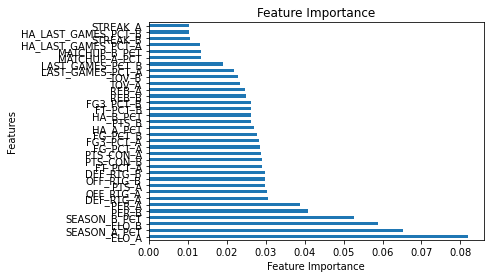

In [428]:
feature_importance_dataset = whole_dataset.loc[(whole_dataset['SEASON_ID'] >= first_season) & (whole_dataset['SEASON_ID'] < int(results[0]['seasons'].split('-')[1]))].reset_index(drop=True)
feature_importance_classifier = train_rf_model(feature_importance_dataset[selected_columns + ['WINNER']])
get_feature_importance(feature_importance_classifier)

In [429]:
# result_for_analysis = results[0]
result_for_analysis = profit_by_model["['Random Forest', 'Gradient Boosting']"][7]

In [430]:
bets_df = result_for_analysis['bets_df']
bets_df['chosen_odds'] = bets_df.apply (lambda row: row['h_odds'] if row['pred'] == 'H' else row['a_odds'], axis=1)
bets_df['p_chosen_odds'] = bets_df.apply (lambda row: row['p_h_odds'] if row['pred'] == 'H' else row['p_a_odds'], axis=1)
filtered_bets = bets_df.loc[(bets_df['pred'] != bets_df['actual']) & (bets_df['chosen_odds'] > min_threshold) & (bets_df['chosen_odds'] < max_threshold)]
print(filtered_bets['p_chosen_odds'].mean())
print(len(filtered_bets.index))
# for index, row in filtered_bets.iterrows():
#     print(f"\nPred: {row['pred']} \nActual: {row['actual']} \nP_Odds: {row['p_chosen_odds']} \nOdds: {row['chosen_odds']}")

1.7385137574305016
134


In [431]:
print(result_for_analysis['outcome_distribution'])

{'H': 617, 'A': 293}


In [432]:
print('\nPlotting charts...')

models_tracking =  [np.array([x['total_bankroll'] for x in result_for_analysis['results']], dtype=np.float32)]

money_by_date = np.array([[r['date'], r['total_bankroll']] for r in result_for_analysis['results']], dtype=str)
correct_bets = list(filter(lambda x: x[3] == 1, result_for_analysis['bets']))
missed_bets = list(filter(lambda x: x[3] == 0, result_for_analysis['bets']))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(result_for_analysis['profit_by_team'].items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


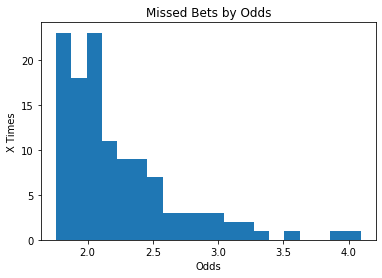

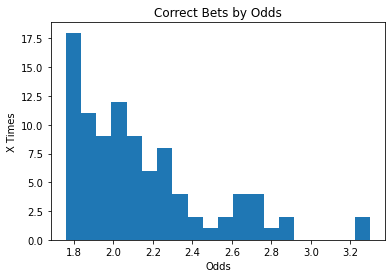

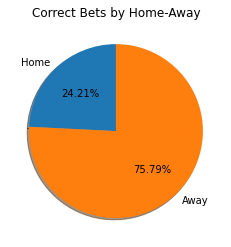

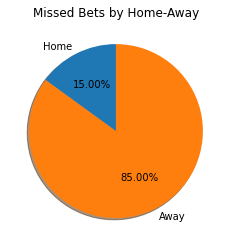

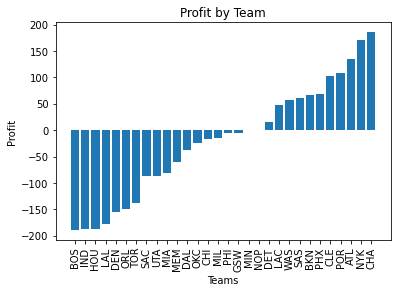

In [433]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

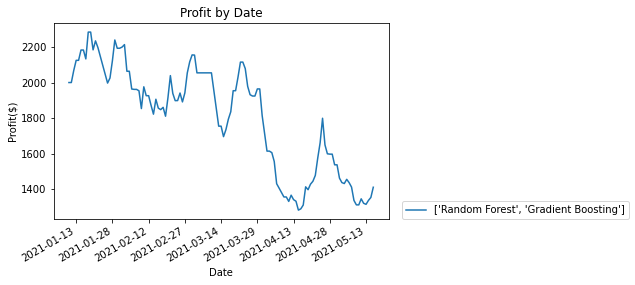

In [434]:
xpoints = money_by_date[:, 0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)

title = "Profit by Date"
plt.legend([result_for_analysis['models']], loc=(1.04,0))
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()